 # 第四题代码
## 第一问

In [243]:
#引入依赖
!pip install numpy
!pip install scipy
!pip install matplotlib
!pip install statsmodels
!pip install seaborn

import numpy
import scipy.stats
import scipy.optimize
import scipy.special
import math
import seaborn
import copy
import matplotlib.pyplot as plt
import pandas
import pylab
import pickle

首先进行初始化

In [244]:
epsilon = 1e-3
sigma0 = 5
sigmay = 1
sigma0_squared = 25
sigmay_squared = 1
# pi, phi = [],[]
N = 1000

接下来首先生成G,然后再从中抽样，然后生成最后的y.具体算法可以见手写pdf.

In [245]:
def stick_breaking_pi_phi(epsilon, alpha0):
    left_pi = 1
    phi_total = []
    pi_total = []
    while(left_pi >= epsilon):
      phi = numpy.random.normal(0,sigma0,2)
      beta = numpy.random.beta(1,alpha0)
      pi = left_pi * beta
      left_pi *= (1 - beta)
      phi_total.append(phi)
      pi_total.append(pi)
    phi_total  = numpy.array(phi_total)
    pi_total = numpy.array(pi_total)
    return pi_total, phi_total

def DP_theta(pi, phi, N):
    theta = numpy.zeros([N,2])
    theta[:,0] = numpy.random.choice(phi[:,0], N, p=pi/numpy.sum(pi))
    theta[:,1] = numpy.random.choice(phi[:,0], N, p=pi/numpy.sum(pi))
    return theta

alpha0 = 0.1
pi,phi = stick_breaking_pi_phi(epsilon, alpha0)
theta = DP_theta(pi, phi, N)
y = numpy.zeros([N,2])
for i in range(N):
    y[i,] = numpy.random.normal(theta[i,], sigmay, 2)

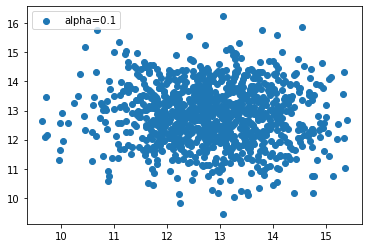

In [246]:
#作图
plt.scatter(y[:,0],y[:,1],label='alpha=0.1')
plt.legend()
plt.show()

对以上过程进行封装，并进行其他$\alpha$值的绘制。

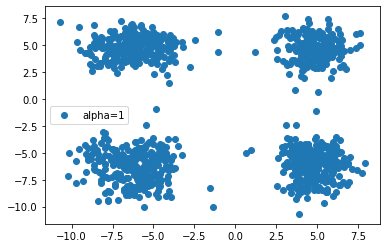

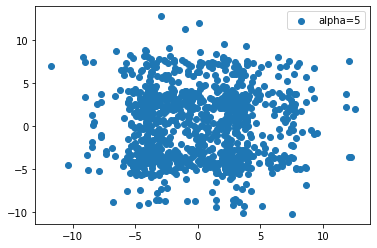

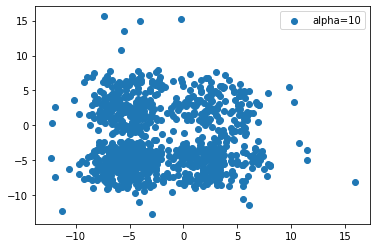

In [247]:
def plot_DP_y(alpha):
    pi,phi = stick_breaking_pi_phi(epsilon, alpha)
    theta = DP_theta(pi, phi, N)
    y = numpy.zeros([N,2])
    for i in range(N):
        y[i,] = numpy.random.normal(theta[i,], sigmay, 2)

    #%%
    #作图
    plt.scatter(y[:,0],y[:,1],label=f'alpha={alpha}')
    plt.legend()
    plt.show()
plot_DP_y(1)
plot_DP_y(5)
plot_DP_y(10)

可以看到，非常明显的是随着$\alpha$增大，我们的DP样本越来越分散。

## 第二问
首先我们实现对应的Collapsed Gibbs抽样。参数的更新法则如下：
$p(z_{i}=k \mid y_{i}, z_{-i}, \phi_{1: K}) \propto\begin{array}{ll}
\frac{m_{k}^{(-i)}}{2 \pi \sigma_{y}^{2}} \exp (-\frac{(y_{i}-\phi_{k})^{T}(y_{i}-\phi_{k})}{2 \sigma_{y}^{2}}), & k \leq K^{(-i)} \\
\frac{\alpha_{0}}{2 \pi(\sigma_{y}^{2}+\sigma_{0}^{2})} \exp (-\frac{y_{i}^{T} y_{i}}{2(\sigma_{y}^{2}+\sigma_{0}^{2})}), & k=K^{(-i)}+1
\end{array}.$

以及

$p\left(\phi_{k} \mid z_{1: n}, y_{1: n}\right) \sim \mathcal{N}\left(\frac{\sigma_{0}^{2}}{m_{k} \sigma_{0}^{2}+\sigma_{y}^{2}} \sum_{i: z_{i}=k} y_{i}, \frac{\sigma_{0}^{2} \sigma_{y}^{2}}{m_{k} \sigma_{0}^{2}+\sigma_{y}^{2}}\right)$

详细推导可以看手写pdf.利用更新公式我们可以立即写出Gibbs Sampler(Collapsed):

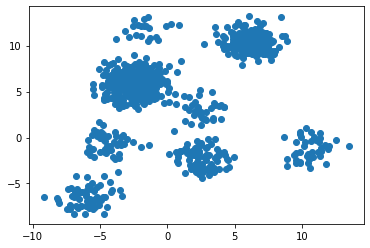

In [248]:
#读入数据
y=numpy.load('btc_hw4_dp_data.npy')
plt.scatter(y[:,0],y[:,1],label='data')

#初始化
z_gibbs = numpy.zeros(N)
K_gibbs = 1
phi_gibbs = numpy.array([numpy.random.normal(0,sigma0,2)])

接下来进行分布的交替更新

In [249]:
#约定类别是自然顺序，传的参数是自然顺序
def m_k(k,y,z, exclude = -1):
    count = 0
    if exclude == -1:
        for i in range(N):
            if abs(z[i] - k) <= 0.5:
                count += 1
        return count
    else:
        for i in range(N):
            if abs(i+1 - exclude) <= 0.5:
                pass
            elif abs(z[i] - k) <= 0.5:
                count += 1
        return count

def Kinds(z, exclude = -1):
    z_temp = z
    z_temp[exclude-1] = 0
    if exclude == -1:
        return len(set(z))
    else:
        # if len(set(z_temp))-1 > 0:
        return len(set(z_temp))-1
        # else:
        #     return 1

def update_z_gibbs(k,y,z,i,phi):
    # print(k,Kinds(z, i))
    if k <= Kinds(z, i):
        # print(phi[k-1])
        p = m_k(k,y,z, exclude = i)/(2*math.pi*sigmay_squared)*numpy.exp(-numpy.inner(y[i-1,]-phi[k-1,],y[i-1,]-phi[k-1,])/(2*sigmay_squared))
    elif k == Kinds(z, i) + 1:
        p = alpha0/(2*math.pi*(sigmay_squared+sigma0_squared))*numpy.exp(-numpy.inner(y[i-1,],y[i-1,])/(2*(sigma0_squared+sigmay_squared)))
    return p

def update_phi_gibbs(k,y,z,phi):
    sumy = 0
    for i in range(N):
        if abs(z[i] - k) <= 0.5:
            sumy += y[i]
    mean = sigma0_squared*sumy/(m_k(k,y,z)*sigma0_squared+sigmay_squared)
    std = sigma0*sigmay/((m_k(k,y,z)*sigma0_squared+sigmay_squared)**0.5)
    return numpy.random.normal(mean,std,2)

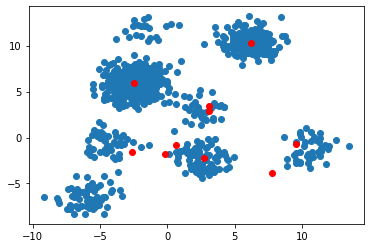

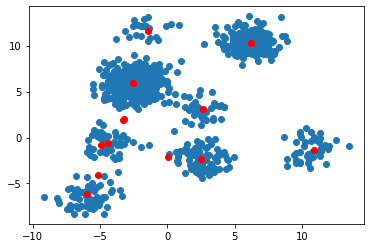

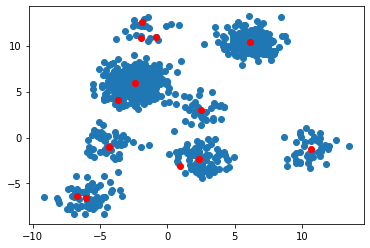

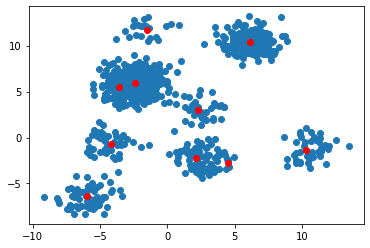

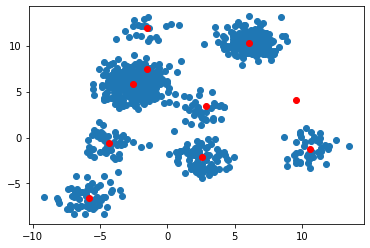

In [250]:
#Gibbs
T = 150
check = [9,14,19,29,49]
K_record = []
for t in range(T):
    # for i in range(N):
    #     z_gibbs_old[i] = z_gibbs[i]
    z_gibbs_old = copy.deepcopy(z_gibbs)
    phi_gibbs_old = copy.deepcopy(phi_gibbs)
    K_new = Kinds(z_gibbs)
    K_record.append(K_new)
    phi_gibbs = numpy.zeros([K_new,2])
    for k in range(K_new):
        # print(k)
        phi_gibbs[k] = update_phi_gibbs(k+1,y,z_gibbs_old,phi_gibbs_old)
    for i in range(N):

        K_minus_i = Kinds(z_gibbs_old, exclude=i+1)
        # print(K_minus_i+1)
        probability = numpy.zeros(K_minus_i+1)
        for k in range(K_minus_i+1):
            probability[k] = update_z_gibbs(k+1,y,z_gibbs_old,i+1,phi_gibbs)
        # print(numpy.array(range(K_minus_i+1)))
        z_gibbs[i] = numpy.random.choice(numpy.array(range(K_minus_i+1)), 1, p = probability/numpy.sum(probability))+1

    if t in check:
        plt.scatter(y[:,0],y[:,1],label='data')
        plt.scatter(phi_gibbs[:,0],phi_gibbs[:,1],color = 'red',label=f'iterations = {t}, K = {K_new}')
        plt.show()


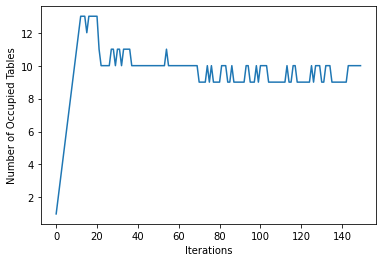

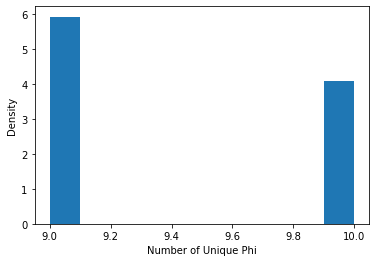

In [253]:
plt.plot(numpy.arange(T),K_record)
plt.xlabel('Iterations')
plt.ylabel('Number of Occupied Tables')
plt.show()
plt.hist(K_record[100:-1],density=True,align='mid')
plt.xlabel('Number of Unique Phi')
plt.ylabel('Density')
plt.show()

## 第三问

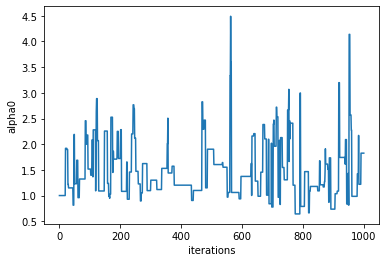

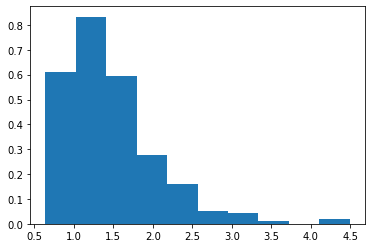

In [269]:
#首先写出MH算法
def accept_rate(alpha_old, alpha_new, K, alpha, beta):
  ans=1.0
  for i in range(N):
    ans*=(alpha_old+i)/(alpha_new+i)
  ans*=(alpha_new/alpha_old)**K
  return ans

sample_size=1000
def MH(K_m, alpha, beta):
  alpha_rec=numpy.zeros(sample_size)
  alpha_rec[0]=1
  for t in range(1,sample_size):
    new_alpha=scipy.stats.gamma.rvs(a=alpha,loc=0,scale=beta)
    p=accept_rate(alpha_rec[t-1],new_alpha,K_m, alpha, beta)
    rd=numpy.random.uniform(0,1)
    if(rd<p):
      alpha_rec[t]=new_alpha
    else:
      alpha_rec[t]=alpha_rec[t-1]
  return alpha_rec

alpha_rec=MH(9,2 ,3)
plt.figure(1)
plt.plot(numpy.arange(sample_size),alpha_rec)
plt.xlabel('iterations')
plt.ylabel('alpha0')

plt.figure(2)
plt.hist(alpha_rec[500:-1],density=True,align='mid')
plt.show()

具体算法见手写pdf.接下来我们对不同的$\alpha, \beta$进行聚类，并分析$k$的和$\alpha$后验的变化。

In [277]:
alpha = 10
beta = 0.1
alpha0 = scipy.stats.gamma.rvs(a= alpha,loc=0,scale=beta)
T = 100
K_record = []
for t in range(T):
    # for i in range(N):
    #     z_gibbs_old[i] = z_gibbs[i]
    z_gibbs_old = copy.deepcopy(z_gibbs)
    phi_gibbs_old = copy.deepcopy(phi_gibbs)
    K_new = Kinds(z_gibbs)
    K_record.append(K_new)
    phi_gibbs = numpy.zeros([K_new,2])
    for k in range(K_new):
        # print(k)
        phi_gibbs[k] = update_phi_gibbs(k+1,y,z_gibbs_old,phi_gibbs_old)
    for i in range(N):

        K_minus_i = Kinds(z_gibbs_old, exclude=i+1)
        # print(K_minus_i+1)
        probability = numpy.zeros(K_minus_i+1)
        for k in range(K_minus_i+1):
            probability[k] = update_z_gibbs(k+1,y,z_gibbs_old,i+1,phi_gibbs)
        # print(numpy.array(range(K_minus_i+1)))
        z_gibbs[i] = numpy.random.choice(numpy.array(range(K_minus_i+1)), 1, p = probability/numpy.sum(probability))+1


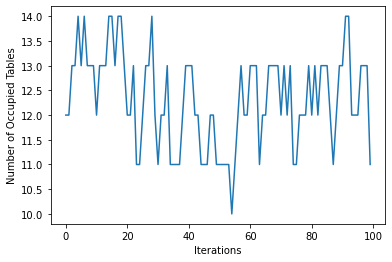

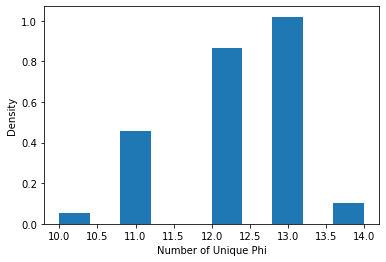

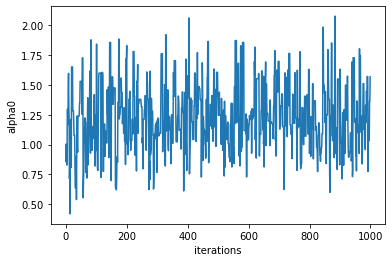

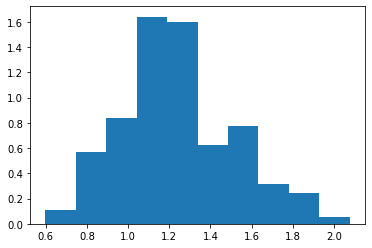

In [278]:
plt.plot(numpy.arange(T),K_record)
plt.xlabel('Iterations')
plt.ylabel('Number of Occupied Tables')
plt.show()
plt.hist(K_record[50:-1],density=True,align='mid')
plt.xlabel('Number of Unique Phi')
plt.ylabel('Density')
plt.show()
alpha_rec=MH(K_new,alpha, beta)
plt.figure(1)
plt.plot(numpy.arange(sample_size),alpha_rec)
plt.xlabel('iterations')
plt.ylabel('alpha0')

plt.figure(2)
plt.hist(alpha_rec[500:-1],density=True,align='mid')
plt.show()

In [279]:
alpha = 1
beta = 1
alpha0 = scipy.stats.gamma.rvs(a= alpha,loc=0,scale=beta)
T = 100
K_record = []
for t in range(T):
    # for i in range(N):
    #     z_gibbs_old[i] = z_gibbs[i]
    z_gibbs_old = copy.deepcopy(z_gibbs)
    phi_gibbs_old = copy.deepcopy(phi_gibbs)
    K_new = Kinds(z_gibbs)
    K_record.append(K_new)
    phi_gibbs = numpy.zeros([K_new,2])
    for k in range(K_new):
        # print(k)
        phi_gibbs[k] = update_phi_gibbs(k+1,y,z_gibbs_old,phi_gibbs_old)
    for i in range(N):

        K_minus_i = Kinds(z_gibbs_old, exclude=i+1)
        # print(K_minus_i+1)
        probability = numpy.zeros(K_minus_i+1)
        for k in range(K_minus_i+1):
            probability[k] = update_z_gibbs(k+1,y,z_gibbs_old,i+1,phi_gibbs)
        # print(numpy.array(range(K_minus_i+1)))
        z_gibbs[i] = numpy.random.choice(numpy.array(range(K_minus_i+1)), 1, p = probability/numpy.sum(probability))+1


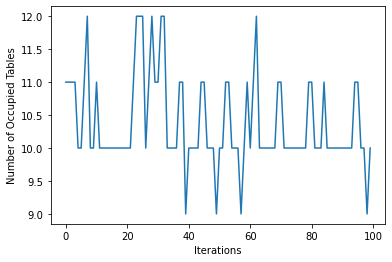

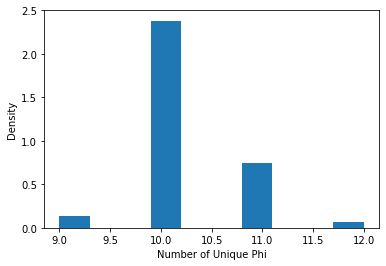

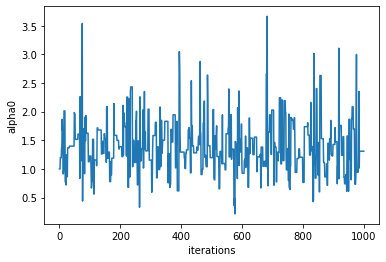

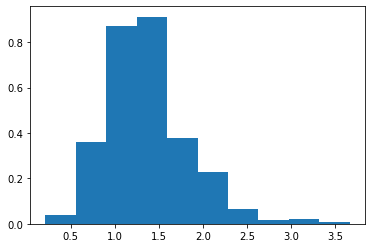

In [280]:
plt.plot(numpy.arange(T),K_record)
plt.xlabel('Iterations')
plt.ylabel('Number of Occupied Tables')
plt.show()
plt.hist(K_record[50:-1],density=True,align='mid')
plt.xlabel('Number of Unique Phi')
plt.ylabel('Density')
plt.show()
alpha_rec=MH(K_new,alpha, beta)
plt.figure(1)
plt.plot(numpy.arange(sample_size),alpha_rec)
plt.xlabel('iterations')
plt.ylabel('alpha0')

plt.figure(2)
plt.hist(alpha_rec[500:-1],density=True,align='mid')
plt.show()

In [281]:
alpha = 0.1
beta = 10
alpha0 = scipy.stats.gamma.rvs(a= alpha,loc=0,scale=beta)
T = 100
K_record = []
for t in range(T):
    # for i in range(N):
    #     z_gibbs_old[i] = z_gibbs[i]
    z_gibbs_old = copy.deepcopy(z_gibbs)
    phi_gibbs_old = copy.deepcopy(phi_gibbs)
    K_new = Kinds(z_gibbs)
    K_record.append(K_new)
    phi_gibbs = numpy.zeros([K_new,2])
    for k in range(K_new):
        # print(k)
        phi_gibbs[k] = update_phi_gibbs(k+1,y,z_gibbs_old,phi_gibbs_old)
    for i in range(N):

        K_minus_i = Kinds(z_gibbs_old, exclude=i+1)
        # print(K_minus_i+1)
        probability = numpy.zeros(K_minus_i+1)
        for k in range(K_minus_i+1):
            probability[k] = update_z_gibbs(k+1,y,z_gibbs_old,i+1,phi_gibbs)
        # print(numpy.array(range(K_minus_i+1)))
        z_gibbs[i] = numpy.random.choice(numpy.array(range(K_minus_i+1)), 1, p = probability/numpy.sum(probability))+1


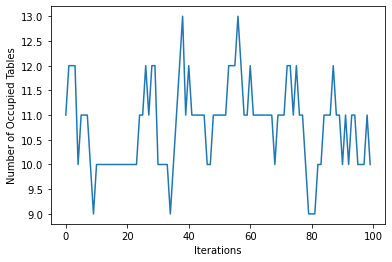

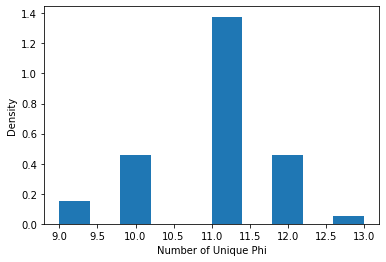

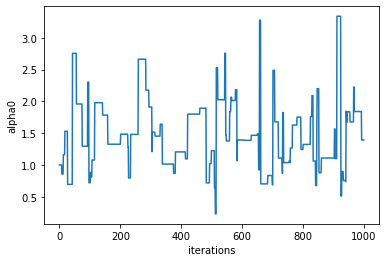

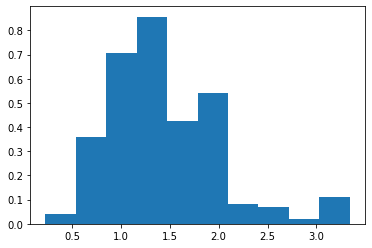

In [282]:
plt.plot(numpy.arange(T),K_record)
plt.xlabel('Iterations')
plt.ylabel('Number of Occupied Tables')
plt.show()
plt.hist(K_record[50:-1],density=True,align='mid')
plt.xlabel('Number of Unique Phi')
plt.ylabel('Density')
plt.show()
alpha_rec=MH(K_new,alpha, beta)
plt.figure(1)
plt.plot(numpy.arange(sample_size),alpha_rec)
plt.xlabel('iterations')
plt.ylabel('alpha0')

plt.figure(2)
plt.hist(alpha_rec[500:-1],density=True,align='mid')
plt.show()

## 第四问 分析
由此可见，在保持期望$\alpha \cdot \beta = 1$时，无论是vague gamma prior，甚至是偏好比较强的prior，结果几乎都是一样的，不是很敏感。

然而，在破坏这个期望条件的时候变化将非常大。这是很自然的，因为第二问中我们直接就取了$\alpha_0 = 1$,为了与它进行比较，我们当然要限制期望为1.